### 这个后期我们讨论怎么改

In [ ]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

# 环境设置
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
warnings.filterwarnings("ignore")

def jump_up_one_dir():
    new_dir = Path().resolve().parent
    os.chdir(new_dir)
    print("✅ 当前工作目录跳转至:", new_dir)

jump_up_one_dir()

In [ ]:
# 加载数据/home/musg/code_file/2025/T1-data
# 导入数据
file_fold = './0-dataset/'  
adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
print("✅ h5ad读取数据完成！")

## 这里图的尺寸受 s=50控制，可以生成一个不失真的

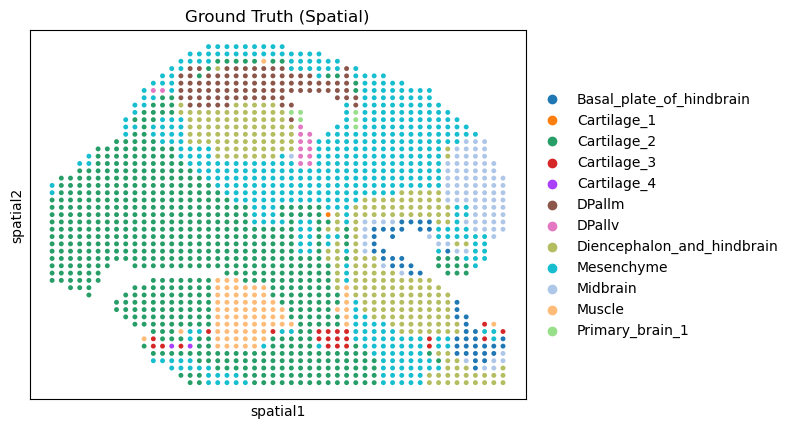

In [ ]:
#
sc.pl.embedding(adata_omics1, basis='spatial', color='final_annot', title='Ground Truth (Spatial)', s=50)

In [ ]:
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
adata_omics1 = adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.uns['true_data'] = adata_omics1.X.copy()
print("✅ 预处理数据完成！")

In [ ]:
# Step 1: 数据划分
x_coords_omics2 = adata_omics2.obsm['spatial'][:, 1]  # X 轴在第 1 列
sorted_indices = np.argsort(x_coords_omics2)

# 自定义缺失比例（例如50%）
missing_ratio = 0.5
split_size = int(adata_omics2.shape[0] * missing_ratio)
split1_indices = sorted_indices[:split_size]

# 标记缺失和非缺失
adata_omics2.obs['missing'] = '1'  # 初始为非缺失
adata_omics2.obs.iloc[split1_indices, adata_omics2.obs.columns.get_loc('missing')] = '0'  # 标记缺失部分

# 2. 蛋白数据预处理
missing_indices = np.where(adata_omics2.obs['missing'] == '0')[0]  # 缺失部分
non_missing_indices = np.where(adata_omics2.obs['missing'] == '1')[0]  # 非缺失部分

# 对于缺失部分和非缺失部分分别进行预处理
adata_omics2_missing = adata_omics2[missing_indices].copy()
adata_omics2_non_missing = adata_omics2[non_missing_indices].copy()

# 预处理设置
#1
#adata_omics2_missing = clr_normalize_each_cell(adata_omics2_missing)
sc.pp.normalize_total(adata_omics2_missing, target_sum=1e4)
sc.pp.log1p(adata_omics2_missing)
#2
#adata_omics2_non_missing = clr_normalize_each_cell(adata_omics2_non_missing)
sc.pp.normalize_total(adata_omics2_non_missing, target_sum=1e4)
sc.pp.log1p(adata_omics2_non_missing)
# 重新生成预处理后的掩码矩阵
mask_protein_A_missing = np.zeros((adata_omics2_missing.shape[0], adata_omics2_missing.shape[1]))
mask_protein_A_non_missing = np.ones((adata_omics2_non_missing.shape[0], adata_omics2_non_missing.shape[1]))

# 将预处理过的数据和掩码矩阵添加到原始的adata_omics2中
adata_omics2.X[missing_indices] = adata_omics2_missing.X
adata_omics2.X[non_missing_indices] = adata_omics2_non_missing.X

print("✅ 蛋白数据预处理完成！")

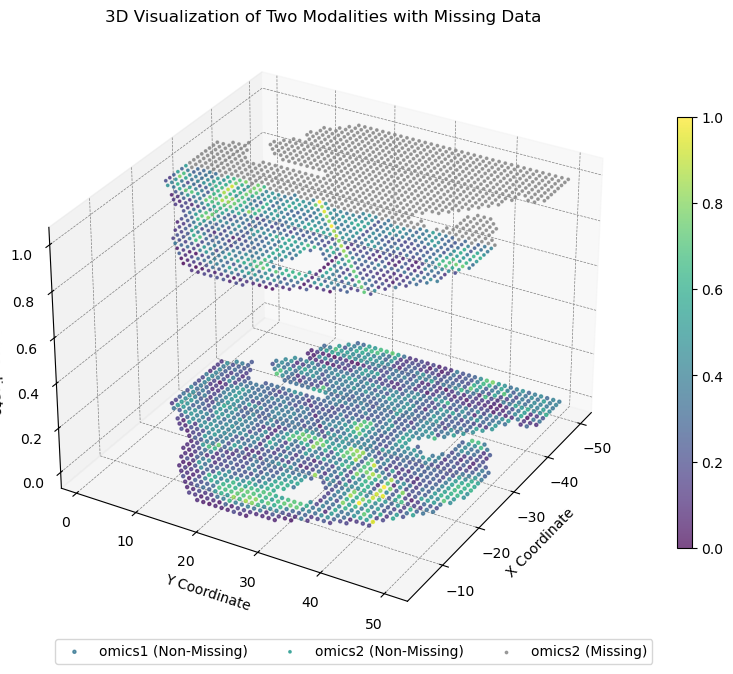

In [ ]:
# 提取两个模态的空间坐标
x_coords_omics1 = adata_omics1.obsm['spatial'][:, 1]
y_coords_omics1 = adata_omics1.obsm['spatial'][:, 0]

x_coords_omics2 = adata_omics2.obsm['spatial'][:, 1]
y_coords_omics2 = adata_omics2.obsm['spatial'][:, 0]

# 创建三维图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 设置 Z 轴坐标，omics1 在 Z=0，omics2 在 Z=1
z_coords_omics1 = np.zeros_like(x_coords_omics1)
z_coords_omics2 = np.ones_like(x_coords_omics2)

# 提取细胞表达量作为颜色映射的依据
# 假设表达量存储在 adata_omics1.X 和 adata_omics2.X 中
expression_omics1 = np.sum(adata_omics1.X, axis=1)  # 每个细胞的总表达量
expression_omics2 = np.sum(adata_omics2.X, axis=1)  # 每个细胞的总表达量

# 归一化表达量以便映射到颜色
expression_omics1 = (expression_omics1 - np.min(expression_omics1)) / (np.max(expression_omics1) - np.min(expression_omics1))
expression_omics2 = (expression_omics2 - np.min(expression_omics2)) / (np.max(expression_omics2) - np.min(expression_omics2))

# 绘制 omics1 数据点（全部为非缺失，颜色表示表达量）
scatter_omics1 = ax.scatter(x_coords_omics1, y_coords_omics1, z_coords_omics1, 
                            c=expression_omics1, cmap='viridis', s=5, alpha=0.7, label='omics1 (Non-Missing)')

# 创建 omics2 缺失和非缺失的掩码
missing_mask_omics2 = adata_omics2.obs['missing'] == '0'
non_missing_mask_omics2 = adata_omics2.obs['missing'] == '1'

# 绘制 omics2 非缺失数据点（颜色表示表达量）
scatter_omics2_non_missing = ax.scatter(x_coords_omics2[non_missing_mask_omics2], y_coords_omics2[non_missing_mask_omics2], z_coords_omics2[non_missing_mask_omics2], 
                                        c=expression_omics2[non_missing_mask_omics2], cmap='viridis', s=3, alpha=0.7, label='omics2 (Non-Missing)')

# 绘制 omics2 缺失数据点（用灰色表示）
ax.scatter(x_coords_omics2[missing_mask_omics2], y_coords_omics2[missing_mask_omics2], z_coords_omics2[missing_mask_omics2], 
           c='gray', s=3, alpha=0.7, label='omics2 (Missing)')

# 设置坐标轴标签
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# 设置网格线为虚线
ax.xaxis._axinfo['grid'] = {'linewidth': 0.5, 'color': 'gray', 'linestyle': '--'}
ax.yaxis._axinfo['grid'] = {'linewidth': 0.5, 'color': 'gray', 'linestyle': '--'}
ax.zaxis._axinfo['grid'] = {'linewidth': 0.5, 'color': 'gray', 'linestyle': '--'}

# 设置背景颜色为白色
ax.set_facecolor('white')

# 添加颜色条并调整大小和位置
# cbar = fig.colorbar(scatter_omics1, ax=ax, label='Expression Level', shrink=0.7, pad=0.05, aspect=30)
cbar = fig.colorbar(scatter_omics1, ax=ax, shrink=0.7, pad=0.05, aspect=30)

# 添加图例和标题
# ax.legend(bbox_to_anchor=(1, 0.8), loc='upper center')  # 通过数值设置图例位置
ax.legend(bbox_to_anchor=(0.55, -0.05),loc='lower center', ncol=3)  # 通过数值设置图例位置

ax.set_title('3D Visualization of Two Modalities with Missing Data',pad=0)

# 调整视角
ax.view_init(elev=25, azim=45)

# 显示图形
plt.show()